In [22]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget
%pdb off

from pyCascade import probePost, physics, utils, probeReadWrite
from pyCascade.probeReadWrite import read_probes_file_switch
from matplotlib import pyplot as plt
from matplotlib import cm, colors
import numpy as np
import scipy as sp
import os
from IPython.core.debugger import set_trace
import pandas as pd
import seaborn as sns
from fnmatch import fnmatch
from cycler import cycler
import plotly.express as px
import plotly
import plotly.graph_objects as go
from plotly.offline import plot
from plotly.subplots import make_subplots
from IPython.display import display, HTML
plotly.offline.init_notebook_mode()
display(HTML(
    '<script type="text/javascript" async src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.1/MathJax.js?config=TeX-MML-AM_SVG"></script>'
))

plt.rcParams['figure.dpi'] = 140
im_scaling = .75
plt.rcParams['figure.figsize'] = [6.4 * im_scaling, 4.8 * im_scaling]

############ Universal ################
scratch_home = os.getenv('SCRATCH') #need to set SCRATCH (even if there is no real SCRATCH) to the location where results are written
scratch_dir = f'{scratch_home}/Cascade/city_block_cfd'
home_dir = !pwd
home_dir = home_dir[0]

display(scratch_dir)
display(home_dir)
plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


'/scratch/users/nbachand/Cascade/city_block_cfd'

'/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd'

In [2]:
hm = 6
window_dim = hm/2/4
velTenMeters = 4

velocity_scaling = 1/velTenMeters
ventilation_scaling = velocity_scaling/(window_dim**2)

@utils.no_kwargs
@utils.dict_apply
def norm_vel(df):
    return df * velocity_scaling

@utils.no_kwargs
@utils.dict_apply
def norm_vent(df):
    return df * ventilation_scaling

@utils.no_kwargs
@utils.dict_apply
def abs_values(df):
    return df.abs()

@utils.no_kwargs
@utils.dict_apply
def flip_data(df):
    return -df


In [3]:
qoisOutputed = ["mass_flux", "comp(u,0)"]
qois= ["mass_flux"]

In [4]:
runs = {
    234: {'B': False, 'A': 0,  'WS': 4, 'C': 2},
    233: {'B': False, 'A': 45, 'WS': 4, 'C': 2},
    # 217: {'B': False, 'A': 0,  'WS': 2, 'C': 2},
    221: {'B': True,  'A': 0,  'WS': 4, 'C': 2},
    222: {'B': False, 'A': 45, 'WS': 2, 'C': 2},
    223: {'B': True,  'A': 0,  'WS': 2, 'C': 2},
    224: {'B': True,  'A': 45, 'WS': 2, 'C': 2},
    225: {'B': True,  'A': 45, 'WS': 4, 'C': 2},
    227: {'B': True,  'A': 45, 'WS': 6, 'C': 2},
    228: {'B': True,  'A': 0,  'WS': 6, 'C': 2},
    229: {'B': False, 'A': 0,  'WS': 6, 'C': 2},
    230: {'B': False, 'A': 45, 'WS': 6, 'C': 2},
    # 301: {'B': False, 'A': 0,  'WS': 4, 'C': 3},
    # 302: {'B': False, 'A': 45, 'WS': 4, 'C': 3},
    # 303: {'B': False, 'A': 0,  'WS': 2, 'C': 3},
    # 304: {'B': False, 'A': 45, 'WS': 2, 'C': 3},
}


In [5]:
delT = 4
for run in runs:
    runs[run]["Ri"] = physics.getVentRi(delT * runs[run]['B'], runs[run]["WS"])

runs

{234: {'B': False, 'A': 0, 'WS': 4, 'C': 2, 'Ri': 0.0},
 233: {'B': False, 'A': 45, 'WS': 4, 'C': 2, 'Ri': 0.0},
 221: {'B': True, 'A': 0, 'WS': 4, 'C': 2, 'Ri': 0.026028110359187923},
 222: {'B': False, 'A': 45, 'WS': 2, 'C': 2, 'Ri': 0.0},
 223: {'B': True, 'A': 0, 'WS': 2, 'C': 2, 'Ri': 0.10411244143675169},
 224: {'B': True, 'A': 45, 'WS': 2, 'C': 2, 'Ri': 0.10411244143675169},
 225: {'B': True, 'A': 45, 'WS': 4, 'C': 2, 'Ri': 0.026028110359187923},
 227: {'B': True, 'A': 45, 'WS': 6, 'C': 2, 'Ri': 0.011568049048527965},
 228: {'B': True, 'A': 0, 'WS': 6, 'C': 2, 'Ri': 0.011568049048527965},
 229: {'B': False, 'A': 0, 'WS': 6, 'C': 2, 'Ri': 0.0},
 230: {'B': False, 'A': 45, 'WS': 6, 'C': 2, 'Ri': 0.0}}

In [6]:
start = -10 #40000
stop = -1
by = 1

In [7]:
roomQois = ["mean", "net"]

connectedWindows = {
    "corner": [
        "xwindow_0-0",
        "zwindow_0-0",
        "skylight_0-0"
    ],
    "single": [
        "zwindow_1-0",
        "skylight_1-0"
    ],
    "dual": [
        "xwindow_0-1",
        "zwindow_0-1",
        "zwindow_1-1",
        "skylight_0-1",
        "skylight_1-1"
       ],
    "cross": [
        "zwindow_2-0",
        "zwindow_2-1",
        "skylight_2-0",
        "skylight_2-1"
    ]
}


In [8]:
allFlowStats = {}
allRoomVentilation = {}
for i, run in enumerate(runs):
    C = runs[run]['C']
    category = f"config{C}"
    R = run % 100
    probes_dir = f'{home_dir}/CHARLES/{category}/R{R}/probes/probesOut_parquet'
    locations_dir = f'{scratch_dir}/CHARLES/{category}/R{R}/probes/locations'
    print(probes_dir)
    flowStatsPath = f"{probes_dir}/../flowStats.csv"
    roomVentilationPath = f"{probes_dir}/../roomVentiation.csv"
    if os.path.exists(roomVentilationPath) and os.path.exists(flowStatsPath):
        roomVentilation = pd.read_csv(roomVentilationPath, index_col=0)
        flowStats = pd.read_csv(flowStatsPath, index_col=0)
    else:
        raise Exception(f"Run {run} does not has associated ventilation files. Run createVentilationStats.slurm from run folder first.")
        
    allFlowStats[run] = flowStats
    allRoomVentilation[run] = roomVentilation


/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R34/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R33/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R21/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R22/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R23/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R24/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R25/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R27/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARLES/config2/R28/probes/probesOut_parquet
/oak/stanford/groups/gorle/nbachand/Cascade/city_block_cfd/CHARL

In [9]:
flowStatsMI = pd.concat(allFlowStats.values(), keys=allFlowStats.keys())
roomVentilationMI = pd.concat(allRoomVentilation.values(), keys=allRoomVentilation.keys())

display(flowStatsMI["EPR_mag"])
display(roomVentilationMI)


234  xwindow_0-0_h_0--1    3.094347
     zwindow_0-0_h_0--1    3.094347
     zwindow_2-0_h_0--1    3.094347
     zwindow_2-1_h_0--1    3.094347
     xwindow_0-1_h_0--1    3.094347
                             ...   
230  xwindow_0-1_sl_Bz     6.398073
     zwindow_0-1_sl_Bz     6.398073
     zwindow_1-1_sl_Bz     6.398073
     skylight_1-0_sl_Bz    6.398073
     zwindow_1-0_sl_Bz     6.398073
Name: EPR_mag, Length: 2376, dtype: float64

mean       net  \
234 corner_h_0--1_B  0.025642  0.070765   
    cross_h_0--1_B   0.009296  0.058415   
    dual_h_0--1_B    0.043715  0.094997   
    single_h_0--1_B  0.000204  0.000273   
    corner_h_0--2_B  0.021323  0.082151   
...                       ...       ...   
230 single_h_0-2_Bz  0.000952  0.002042   
    corner_sl_Bz     0.572873  0.575417   
    cross_sl_Bz      1.140662  1.166480   
    dual_sl_Bz       0.830815  0.884503   
    single_sl_Bz     0.037152  0.111548   

                                                             EP_normal  \
234 corner_h_0--1_B                 [-0.28558982, 0.13722016479842983]   
    cross_h_0--1_B                 [0.09360142035687233, -0.026384166]   
    dual_h_0--1_B       [-0.3862592275112524, 0.020995501, 0.02619507]   
    single_h_0--1_B                              [0.11507334851518855]   
    corner_h_0--2_B                         [-0.37221398, 0.056224027]   
...                                                                ...   
230 single_h_0-2_Bz                              [0.48489464218565864]   
    corner_sl_Bz     [-0.3069003942795634, -0.19136046583784438, 0....   
    cross_sl_Bz      [-0.36653088469186407, -0.028306815, 0.4754571...   
    dual_sl_Bz       [-0.33372251760631333, 0.0799425345778829, 1.1...   
    single_sl_Bz            [-0.4837366703858377, 0.26638494452585865]   

                      EP_shear   EPR_mag houseType blockType roomType  \
234 corner_h_0--1_B   1.713111  3.094347      0--1         B   corner   
    cross_h_0--1_B    2.710385  3.094347      0--1         B    cross   
    dual_h_0--1_B     2.626013  3.094347      0--1         B     dual   
    single_h_0--1_B   1.446934  3.094347      0--1         B   single   
    corner_h_0--2_B   1.731985  3.717125      0--2         B   corner   
...                        ...       ...       ...       ...      ...   
230 single_h_0-2_Bz   2.977100  6.956279       0-2        Bz   single   
    corner_sl_Bz      8.999839  6.398073        sl        Bz   corner   
    cross_sl_Bz      14.397127  6.398073        sl        Bz    cross   
    dual_sl_Bz       14.201908  6.398073        sl        Bz     dual   
    single_sl_Bz      8.256195  6.398073        sl        Bz   single   

                              x         y          z  nWindows  contResid  \
234 corner_h_0--1_B   47.015594  1.497615  33.055550         2   0.000639   
    cross_h_0--1_B    55.999773  1.497595  36.035254         2  -0.000628   
    dual_h_0--1_B     48.675774  1.500022  39.306152         3   0.000004   
    single_h_0--1_B   51.998942  1.495154  32.111106         1  -0.000407   
    corner_h_0--2_B   55.016136  1.500000   9.022450         2   0.000480   
...                         ...       ...        ...       ...        ...   
230 single_h_0-2_Bz  104.023340  1.499420 -59.997758         1   0.001905   
    corner_sl_Bz      57.358756  1.966833 -39.331883         3  -0.017806   
    cross_sl_Bz       59.999651  2.203340 -48.000003         4   0.031479   
    dual_sl_Bz        62.769886  2.060568 -41.199981         5   0.031399   
    single_sl_Bz      57.039356  2.197882 -44.000548         2  -0.001809   

                     EP_normal_mag  EP_normal_sum  EP_normal_ratio  
234 corner_h_0--1_B       0.422810       0.148370         0.740240  
    cross_h_0--1_B        0.119986       0.067217         0.640939  
    dual_h_0--1_B         0.433450       0.339069         0.561087  
    single_h_0--1_B       0.115073       0.115073         0.500000  
    corner_h_0--2_B       0.428438       0.315990         0.575526  
...                            ...            ...              ...  
230 single_h_0-2_Bz       0.484895       0.484895         0.500000  
    corner_sl_Bz          0.894855       0.101667         0.897978  
    cross_sl_Bz           1.003896       0.052982         0.949870  
    dual_sl_Bz            2.717315       2.049870         0.570004  
    single_sl_Bz          0.750122       0.217352         

In [10]:
# display(roomVentilationMI.iloc[np.argmax(roomVentilationMI["x"])])
display(flowStatsMI[np.abs(flowStatsMI["x"]) > 1000])
display(flowStatsMI[np.abs(flowStatsMI["z"]) > 1000])
display(roomVentilationMI[np.abs(roomVentilationMI["x"]) > 1000])
display(roomVentilationMI[np.abs(roomVentilationMI["z"]) > 1000])
# display(roomVentilationMI[roomVentilationMI["roomType"] == "cross"])


Empty DataFrame
Columns: [mean, rms, net, windowType, openingType, windowNumber, houseType, blockType, area, x, y, z, orientation, EP_x, EP_y, EP_z, EP_comp(u_avg,0), EP_comp(u_avg,1), EP_comp(u_avg,2), EP_mag, EP_vel_orientation, EP_normal, EP_shear, EPR_mag, EPR_vel_orientation, roomType]
Index: []

[0 rows x 26 columns]

Empty DataFrame
Columns: [mean, rms, net, windowType, openingType, windowNumber, houseType, blockType, area, x, y, z, orientation, EP_x, EP_y, EP_z, EP_comp(u_avg,0), EP_comp(u_avg,1), EP_comp(u_avg,2), EP_mag, EP_vel_orientation, EP_normal, EP_shear, EPR_mag, EPR_vel_orientation, roomType]
Index: []

[0 rows x 26 columns]

Empty DataFrame
Columns: [mean, net, EP_normal, EP_shear, EPR_mag, houseType, blockType, roomType, x, y, z, nWindows, contResid, EP_normal_mag, EP_normal_sum, EP_normal_ratio]
Index: []

Empty DataFrame
Columns: [mean, net, EP_normal, EP_shear, EPR_mag, houseType, blockType, roomType, x, y, z, nWindows, contResid, EP_normal_mag, EP_normal_sum, EP_normal_ratio]
Index: []

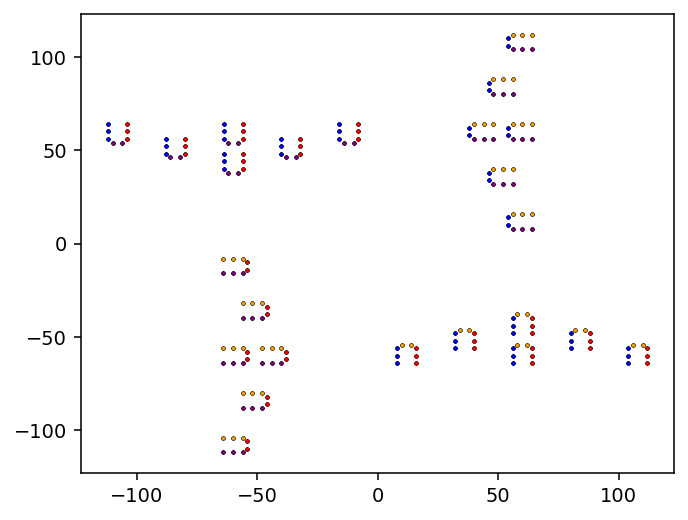

In [11]:
flowStatsMI["orientation"] = pd.Series(dtype=float)

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "B") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bxz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bz"))
    ), "orientation"] = 0

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "B") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bxz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bz"))
    ), "orientation"] = 180

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bz"))
    ) | (                                                                             
        (flowStatsMI.openingType == "zwindow") & (                                    
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "Bxz") |
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]')))& (flowStatsMI.blockType == "B"))
    ), "orientation"] = 90

flowStatsMI.loc[(
        (flowStatsMI.openingType == "xwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '0-?'))) & (flowStatsMI.blockType == "Bx") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '[!0]-?'))) & (flowStatsMI.blockType == "Bz"))
    ) | (
        (flowStatsMI.openingType == "zwindow") & (
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-[!0]'))) & (flowStatsMI.blockType == "Bxz") | 
        (flowStatsMI.windowNumber.apply(lambda str: fnmatch(str, '?-0'))) & (flowStatsMI.blockType == "B"))
    ), "orientation"] = 270
    
fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] ==   0]['x'], flowStatsMI[flowStatsMI["orientation"] ==   0]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] ==  90]['x'], flowStatsMI[flowStatsMI["orientation"] ==  90]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] == 180]['x'], flowStatsMI[flowStatsMI["orientation"] == 180]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(flowStatsMI[flowStatsMI["orientation"] == 270]['x'], flowStatsMI[flowStatsMI["orientation"] == 270]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)

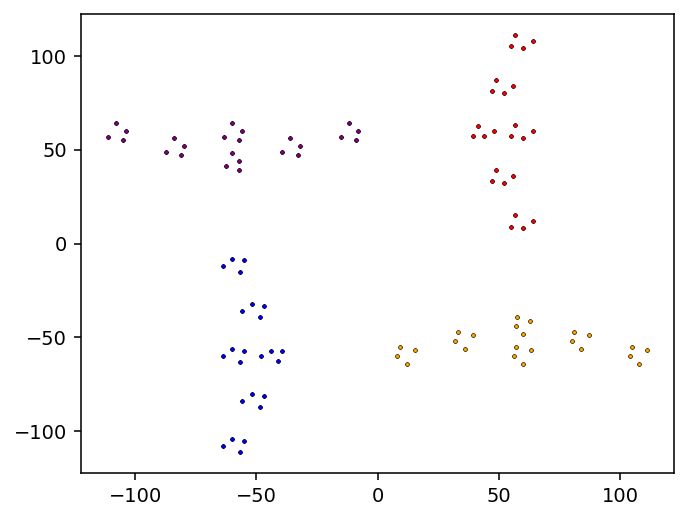

In [12]:

roomVentilationMI["orientation"] = pd.Series(dtype=float)

roomVentilationMI.loc[roomVentilationMI.blockType == "B", "orientation"] = 0
roomVentilationMI.loc[roomVentilationMI.blockType == "Bz", "orientation"] = 90
roomVentilationMI.loc[roomVentilationMI.blockType == "Bxz", "orientation"] =180
roomVentilationMI.loc[roomVentilationMI.blockType == "Bx", "orientation"] = 270

fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] ==   0]['x'], roomVentilationMI[roomVentilationMI["orientation"] ==   0]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] ==  90]['x'], roomVentilationMI[roomVentilationMI["orientation"] ==  90]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] == 180]['x'], roomVentilationMI[roomVentilationMI["orientation"] == 180]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["orientation"] == 270]['x'], roomVentilationMI[roomVentilationMI["orientation"] == 270]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)

In [44]:
def fillInParams(df):
    AofA = pd.Series(index = df.index, dtype = float)
    WS = pd.Series(index = df.index, dtype = float)
    Buoyancy = pd.Series(index = df.index, dtype = bool)
    category = pd.Series(index = df.index, dtype = str)
    Ri = pd.Series(index = df.index, dtype = str)
    Params = pd.Series(index = df.index, dtype = str)
    for index, row in df.iterrows():
        run = index[0]
        angle = runs[run]["A"]
        AofA[index] = (row["orientation"] + angle) % 360
        WS[index] = runs[run]["WS"]
        Buoyancy[index] = runs[run]["B"]
        category[index] = runs[run]["C"]
        Ri[index] = runs[run]["Ri"]
        Params[index] = f"Wind Speed: {WS[index]} m/s; Ri = {Ri[index]:.2f}"
        if category[index] == 2:
            Params[index] += "; High Density"
        elif category[index] == 3:
            Params[index] += "; Low Density"
    df["AofA"] = AofA
    df["AofA_str"] = AofA.apply(lambda i: str(i))
    df["AofA_resid"] = AofA.apply(lambda i: str(i%90))
    df["WS"] = WS
    df["B"] = Buoyancy
    df["C"] = category
    df["Ri"] = Ri
    df["Params"] = Params
    for param in ["mean", "net"]:
        df[f"{param}Norm"] = df[param] / df["WS"] * velTenMeters
        df[f"{param}NormEPR"] = df[param] / df["EPR_mag"] * velTenMeters
        # df["f{param}NormFractional"] = df[f"{param}Norm] / 
    display(df)
    df.sort_values(["C", "WS", "B"])
    return df
flowStatsMI = fillInParams(flowStatsMI)
roomVentilationMI = fillInParams(roomVentilationMI)

mean       rms       net    windowType  \
234 xwindow_0-0_h_0--1  0.025962  0.085287  0.071105   xwindow_0-0   
    zwindow_0-0_h_0--1 -0.025323  0.084396  0.070426   zwindow_0-0   
    zwindow_2-0_h_0--1 -0.009610  0.071192  0.058447   zwindow_2-0   
    zwindow_2-1_h_0--1  0.008982  0.071289  0.058383   zwindow_2-1   
    xwindow_0-1_h_0--1 -0.001186  0.071571  0.057045   xwindow_0-1   
...                          ...       ...       ...           ...   
230 xwindow_0-1_sl_Bz   0.210948  0.217427  0.254452   xwindow_0-1   
    zwindow_0-1_sl_Bz   0.452990  0.194652  0.458116   zwindow_0-1   
    zwindow_1-1_sl_Bz   0.182577  0.208513  0.230509   zwindow_1-1   
    skylight_1-0_sl_Bz -0.038057  0.143175  0.112680  skylight_1-0   
    zwindow_1-0_sl_Bz   0.036248  0.142046  0.110415   zwindow_1-0   

                       openingType windowNumber houseType blockType      area  \
234 xwindow_0-0_h_0--1     xwindow          0-0       3-1         B  0.562500   
    zwindow_0-0_h_0--1     zwindow          0-0       3-1         B  0.575481   
    zwindow_2-0_h_0--1     zwindow          2-0       3-1         B  0.575135   
    zwindow_2-1_h_0--1     zwindow          2-1       3-1         B  0.562500   
    xwindow_0-1_h_0--1     xwindow          0-1       3-1         B  0.563477   
...                            ...          ...       ...       ...       ...   
230 xwindow_0-1_sl_Bz      xwindow          0-1        sl        Bz  0.564852   
    zwindow_0-1_sl_Bz      zwindow          0-1        sl        Bz  0.563764   
    zwindow_1-1_sl_Bz      zwindow          1-1        sl        Bz  0.565068   
    skylight_1-0_sl_Bz    skylight          1-0        sl        Bz  0.577597   
    zwindow_1-0_sl_Bz      zwindow          1-0        sl        Bz  0.563229   

                                x  ...  AofA_resid   WS      B  C   Ri  \
234 xwindow_0-0_h_0--1  46.032316  ...         0.0  4.0  False  2  0.0   
    zwindow_0-0_h_0--1  47.998871  ...         0.0  4.0  False  2  0.0   
    zwindow_2-0_h_0--1  55.999546  ...         0.0  4.0  False  2  0.0   
    zwindow_2-1_h_0--1  56.000000  ...         0.0  4.0  False  2  0.0   
    xwindow_0-1_h_0--1  46.027321  ...         0.0  4.0  False  2  0.0   
...                           ...  ...         ...  ...    ... ..  ...   
230 xwindow_0-1_sl_Bz   61.999991  ...        45.0  6.0  False  2  0.0   
    zwindow_0-1_sl_Bz   63.925112  ...        45.0  6.0  False  2  0.0   
    zwindow_1-1_sl_Bz   63.924364  ...        45.0  6.0  False  2  0.0   
    skylight_1-0_sl_Bz  58.007140  ...         nan  6.0  False  2  0.0   
    zwindow_1-0_sl_Bz   56.071573  ...        45.0  6.0  False  2  0.0   

                                                              Params  \
234 xwindow_0-0_h_0--1  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    zwindow_0-0_h_0--1  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    zwindow_2-0_h_0--1  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    zwindow_2-1_h_0--1  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    xwindow_0-1_h_0--1  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
...                                                              ...   
230 xwindow_0-1_sl_Bz   Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
    zwindow_0-1_sl_Bz   Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
    zwindow_1-1_sl_Bz   Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
    skylight_1-0_sl_Bz  Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
    zwindow_1-0_sl_Bz   Wind Speed: 6.0 m/s; Ri = 0.00; High Density   

                        meanNorm   netNorm  meanNormEPR  netNormEPR  
234 xwindow_0-0_h_0--1  0.025962  0.071105     0.033561    0.091916  
    zwindow_0-0_h_0--1 -0.025323  0.070426    -0.032734    0.091038  
    zwindow_2-0_h_0--1 -0.009610  0.058447    -0.012423    0.075553  
    zwindow_2-1_h_0--1  0.008982  0.058383     0.011611    0.075471  
    xwindow_0-1_h_0--1 -0.001186  0.057045    -0.001533    0.073741  
...                          ...       .

mean       net  \
234 corner_h_0--1_B  0.025642  0.070765   
    cross_h_0--1_B   0.009296  0.058415   
    dual_h_0--1_B    0.043715  0.094997   
    single_h_0--1_B  0.000204  0.000273   
    corner_h_0--2_B  0.021323  0.082151   
...                       ...       ...   
230 single_h_0-2_Bz  0.000952  0.002042   
    corner_sl_Bz     0.572873  0.575417   
    cross_sl_Bz      1.140662  1.166480   
    dual_sl_Bz       0.830815  0.884503   
    single_sl_Bz     0.037152  0.111548   

                                                             EP_normal  \
234 corner_h_0--1_B                 [-0.28558982, 0.13722016479842983]   
    cross_h_0--1_B                 [0.09360142035687233, -0.026384166]   
    dual_h_0--1_B       [-0.3862592275112524, 0.020995501, 0.02619507]   
    single_h_0--1_B                              [0.11507334851518855]   
    corner_h_0--2_B                         [-0.37221398, 0.056224027]   
...                                                                ...   
230 single_h_0-2_Bz                              [0.48489464218565864]   
    corner_sl_Bz     [-0.3069003942795634, -0.19136046583784438, 0....   
    cross_sl_Bz      [-0.36653088469186407, -0.028306815, 0.4754571...   
    dual_sl_Bz       [-0.33372251760631333, 0.0799425345778829, 1.1...   
    single_sl_Bz            [-0.4837366703858377, 0.26638494452585865]   

                      EP_shear   EPR_mag houseType blockType roomType  \
234 corner_h_0--1_B   1.713111  3.094347       3-1         B   corner   
    cross_h_0--1_B    2.710385  3.094347       3-1         B    cross   
    dual_h_0--1_B     2.626013  3.094347       3-1         B     dual   
    single_h_0--1_B   1.446934  3.094347       3-1         B   single   
    corner_h_0--2_B   1.731985  3.717125       3-0         B   corner   
...                        ...       ...       ...       ...      ...   
230 single_h_0-2_Bz   2.977100  6.956279       3-4        Bz   single   
    corner_sl_Bz      8.999839  6.398073        sl        Bz   corner   
    cross_sl_Bz      14.397127  6.398073        sl        Bz    cross   
    dual_sl_Bz       14.201908  6.398073        sl        Bz     dual   
    single_sl_Bz      8.256195  6.398073        sl        Bz   single   

                              x         y  ...  AofA_resid   WS      B  C  \
234 corner_h_0--1_B   47.015594  1.497615  ...         0.0  4.0  False  2   
    cross_h_0--1_B    55.999773  1.497595  ...         0.0  4.0  False  2   
    dual_h_0--1_B     48.675774  1.500022  ...         0.0  4.0  False  2   
    single_h_0--1_B   51.998942  1.495154  ...         0.0  4.0  False  2   
    corner_h_0--2_B   55.016136  1.500000  ...         0.0  4.0  False  2   
...                         ...       ...  ...         ...  ...    ... ..   
230 single_h_0-2_Bz  104.023340  1.499420  ...        45.0  6.0  False  2   
    corner_sl_Bz      57.358756  1.966833  ...        45.0  6.0  False  2   
    cross_sl_Bz       59.999651  2.203340  ...        45.0  6.0  False  2   
    dual_sl_Bz        62.769886  2.060568  ...        45.0  6.0  False  2   
    single_sl_Bz      57.039356  2.197882  ...        45.0  6.0  False  2   

                      Ri                                        Params  \
234 corner_h_0--1_B  0.0  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    cross_h_0--1_B   0.0  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    dual_h_0--1_B    0.0  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    single_h_0--1_B  0.0  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
    corner_h_0--2_B  0.0  Wind Speed: 4.0 m/s; Ri = 0.00; High Density   
...                  ...                                           ...   
230 single_h_0-2_Bz  0.0  Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
    corner_sl_Bz     0.0  Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
    cross_sl_Bz      0.0  Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
    dual_sl_Bz       0.0  Wind Speed: 6.0 m/s; Ri = 0.00; High Density   
   

In [34]:
flowStatsMI["houseType"].replace(["0--2", "0--1", "0-0", "0-1", "0-2"], ['3-0', '3-1', '3-2', '3-3', '3-4'], inplace = True)
roomVentilationMI["houseType"].replace(["0--2", "0--1", "0-0", "0-1", "0-2"], ['3-0', '3-1', '3-2', '3-3', '3-4'], inplace = True)

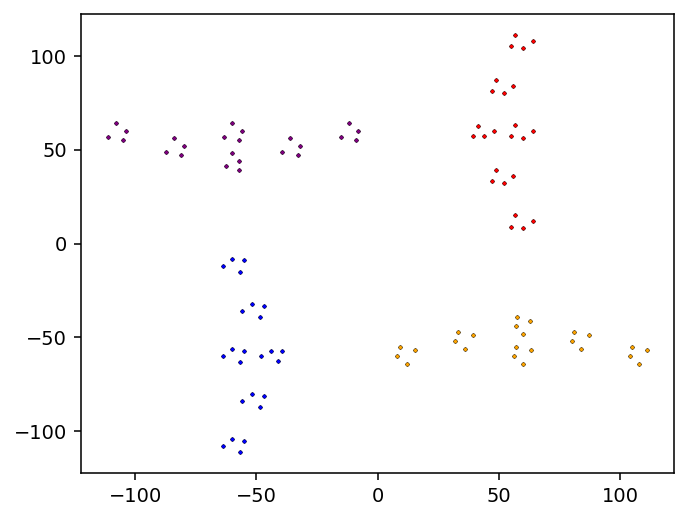

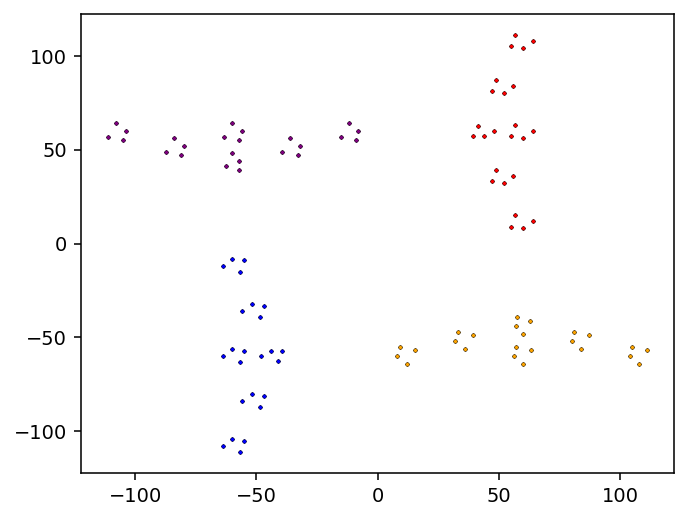

In [35]:
fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] ==   0]['x'], roomVentilationMI[roomVentilationMI["AofA"] ==   0]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] ==  90]['x'], roomVentilationMI[roomVentilationMI["AofA"] ==  90]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] == 180]['x'], roomVentilationMI[roomVentilationMI["AofA"] == 180]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] == 270]['x'], roomVentilationMI[roomVentilationMI["AofA"] == 270]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)
# plt.savefig(f'{home_dir}/CHARLES/{category}/multiPlots/R{run}/plots/rmsInterior', bbox_inches="tight")

fig, ax=plt.subplots(1, 1, constrained_layout =True)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] ==  45]['x'], roomVentilationMI[roomVentilationMI["AofA"] ==   45]['z'], s=4*im_scaling, c="red", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] == 135]['x'], roomVentilationMI[roomVentilationMI["AofA"] ==  135]['z'], s=4*im_scaling, c="orange", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] == 225]['x'], roomVentilationMI[roomVentilationMI["AofA"] ==  225]['z'], s=4*im_scaling, c="blue", edgecolors="black", linewidths=.1)
ax.scatter(roomVentilationMI[roomVentilationMI["AofA"] == 315]['x'], roomVentilationMI[roomVentilationMI["AofA"] ==  315]['z'], s=4*im_scaling, c="purple", edgecolors="black", linewidths=.1)

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the swarmplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the swarmplot function without specifying `hue_order` is likely to produce an incorrect plot.



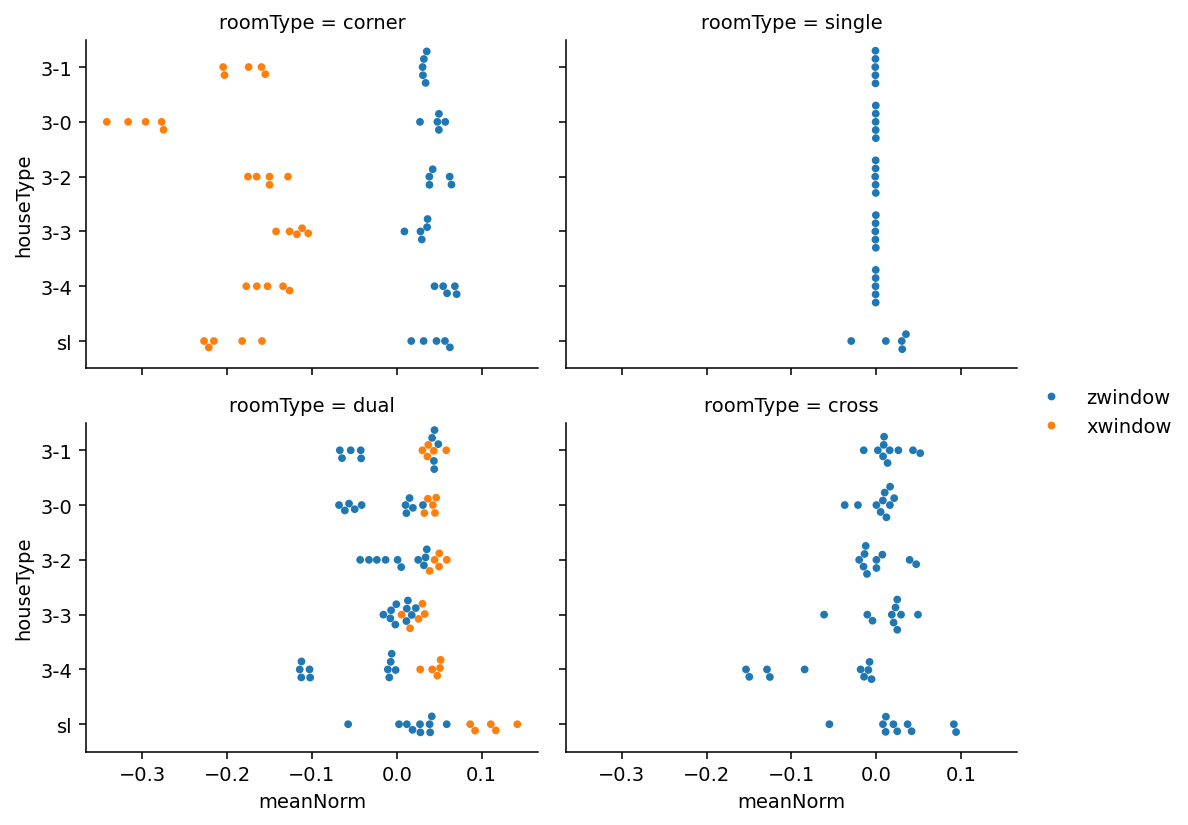

In [36]:
g = sns.FacetGrid(flowStatsMI[flowStatsMI["AofA"] == 90], col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
# g.map(sns.boxplot, "net", "roomType", color = "1", linewidth = 1, fliersize = 0)
g.map(sns.swarmplot, "meanNorm", "houseType", "openingType", palette = "tab10", size = 4)
g.add_legend()

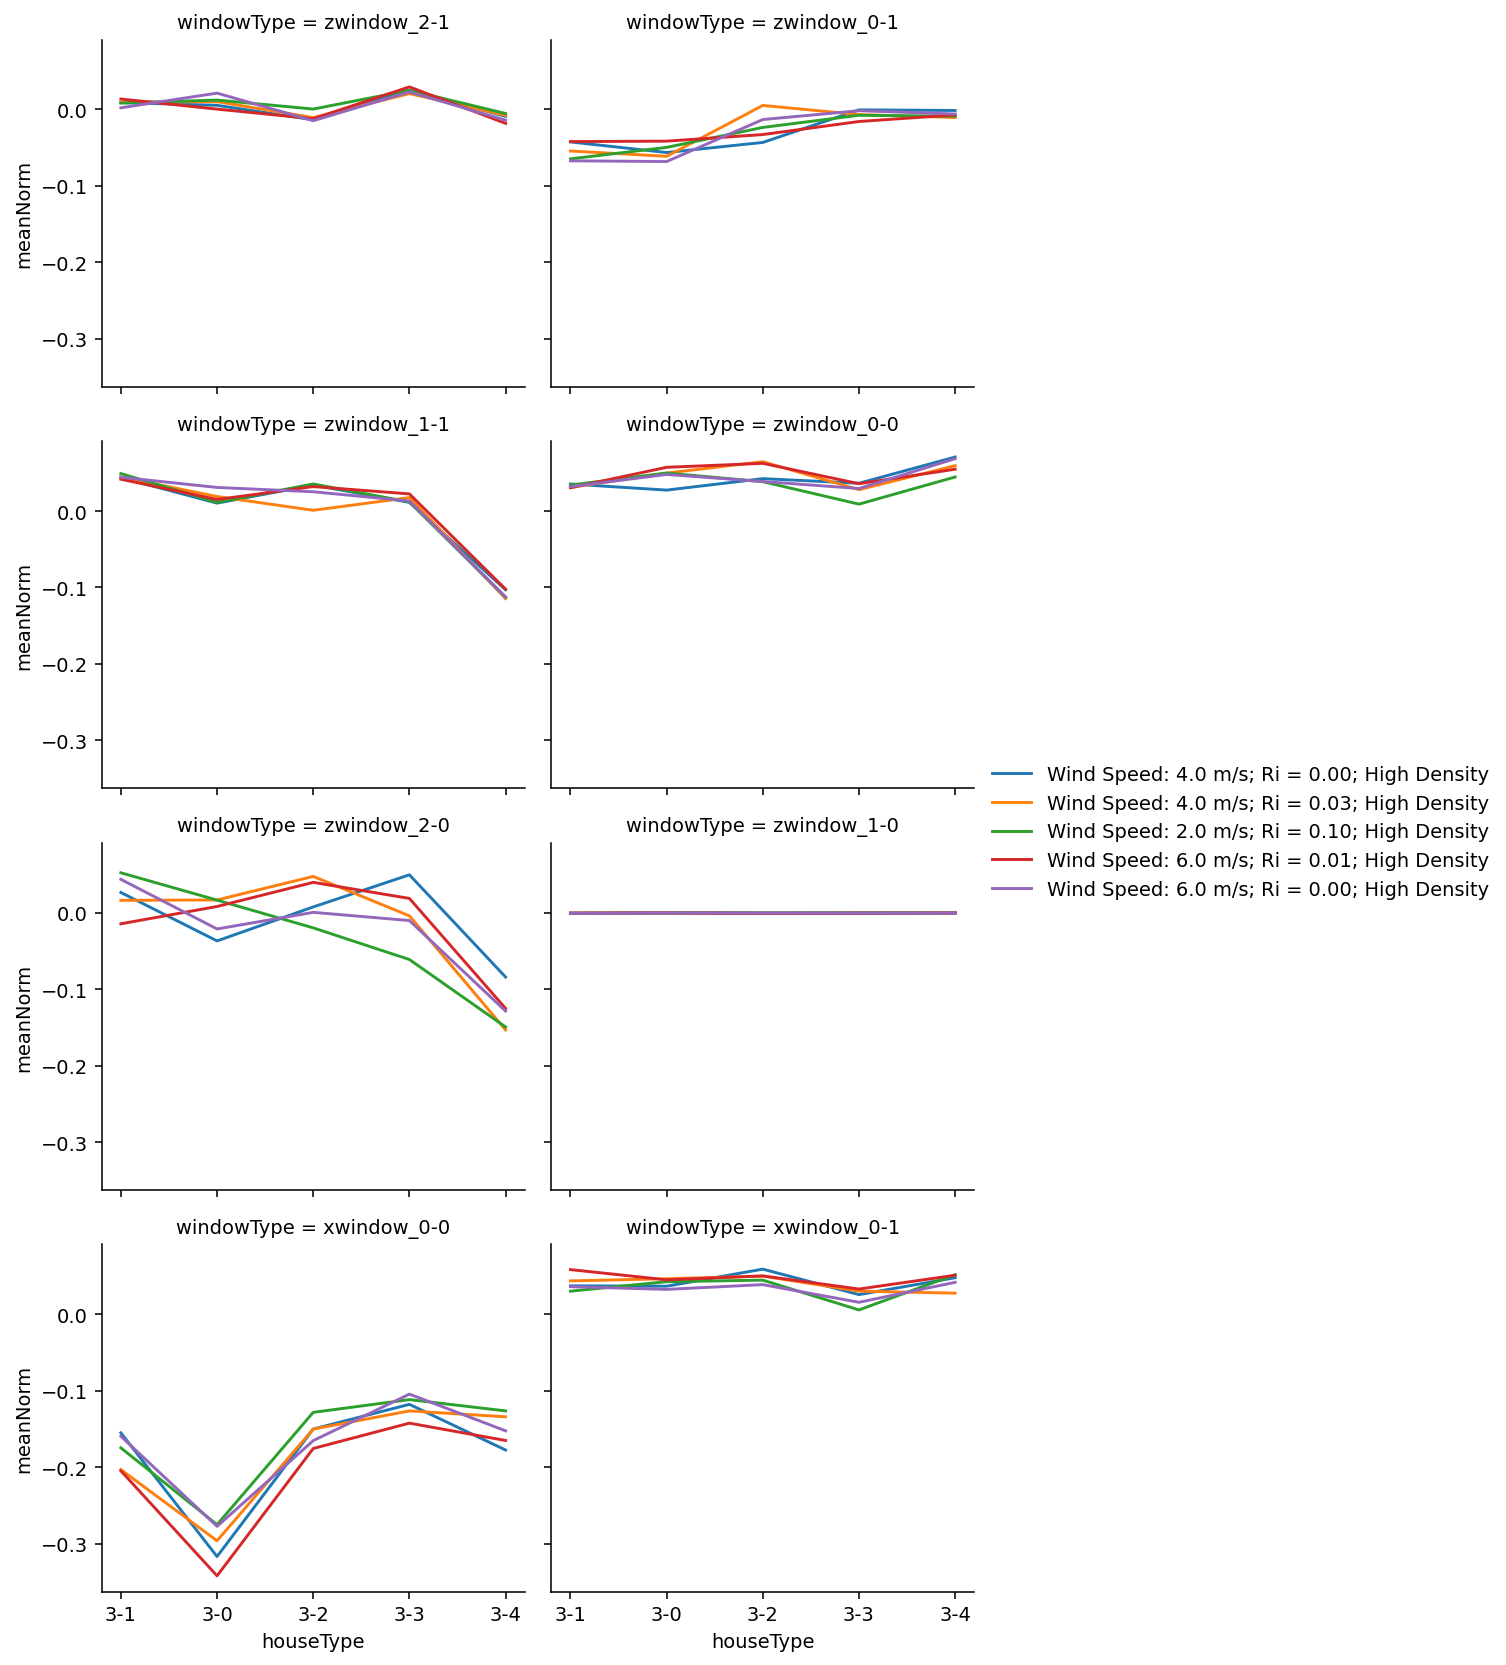

In [37]:
plotdf = flowStatsMI[flowStatsMI["AofA"] == 90]
plotdf = plotdf[plotdf["houseType"] != "sl"]
g = sns.FacetGrid(plotdf, col = "windowType", col_wrap = 2, aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.lineplot, "houseType", "meanNorm", "Params", palette = "tab10")
g.add_legend()

/tmp/ipykernel_4788/1381535364.py:4: UserWarning:


The markers list has fewer values (2) than needed (8) and will cycle, which may produce an uninterpretable plot.



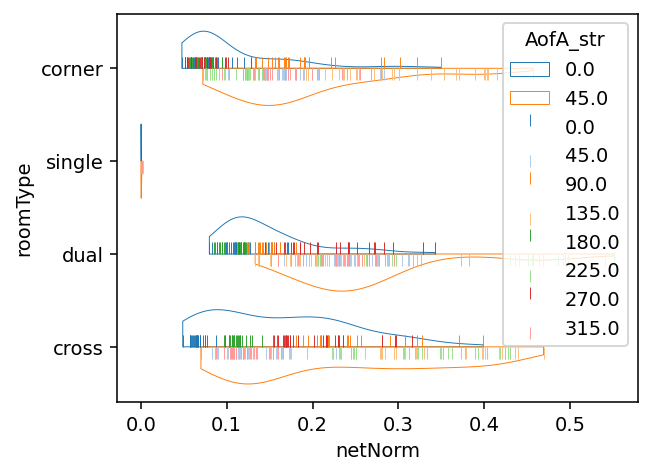

In [38]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] != "sl"]
plotdf = plotdf.sort_values(["AofA"])
g = sns.violinplot(data=plotdf, x="netNorm", y="roomType", hue="AofA_resid", fill = False, inner = None, linewidth = .5, density_norm = "width", cut = 0, split=True)
g = sns.scatterplot(data=plotdf, x="netNorm", y="roomType", hue="AofA_str", style=plotdf["AofA_str"], palette="tab20", markers = [2,3])

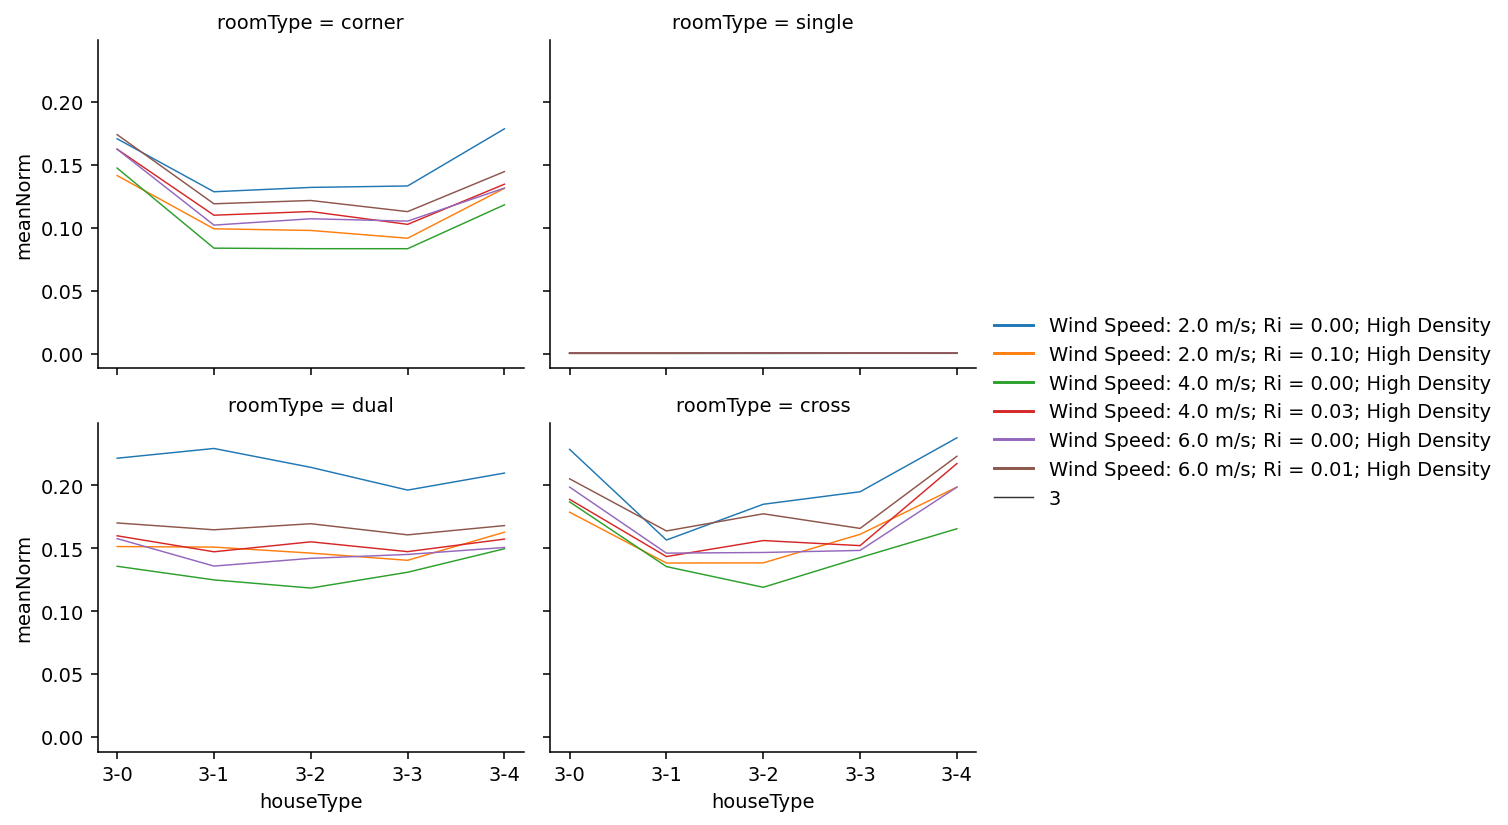

In [39]:
plotdfGrouped = plotdf.groupby(["roomType", "houseType", "Params"], as_index=False).mean(numeric_only = True)
g = sns.FacetGrid(plotdfGrouped, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.violinplot, "meanNorm", "houseType", color = "1", inner = None, linewidth = 1, density_norm = "width", cut = 0)
g.map(sns.lineplot, "houseType", "meanNorm", "Params", palette = "tab10", size = 3)
g.add_legend()


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:718: UserWarning:

Using the violinplot function without specifying `order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:723: UserWarning:

Using the violinplot function without specifying `hue_order` is likely to produce an incorrect plot.

/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs/pycascade/lib/python3.10/site-packages/seaborn/axisgrid.py:854: FutureWarning:



Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.


/home/groups/gorle/codes/miniconda3/envs

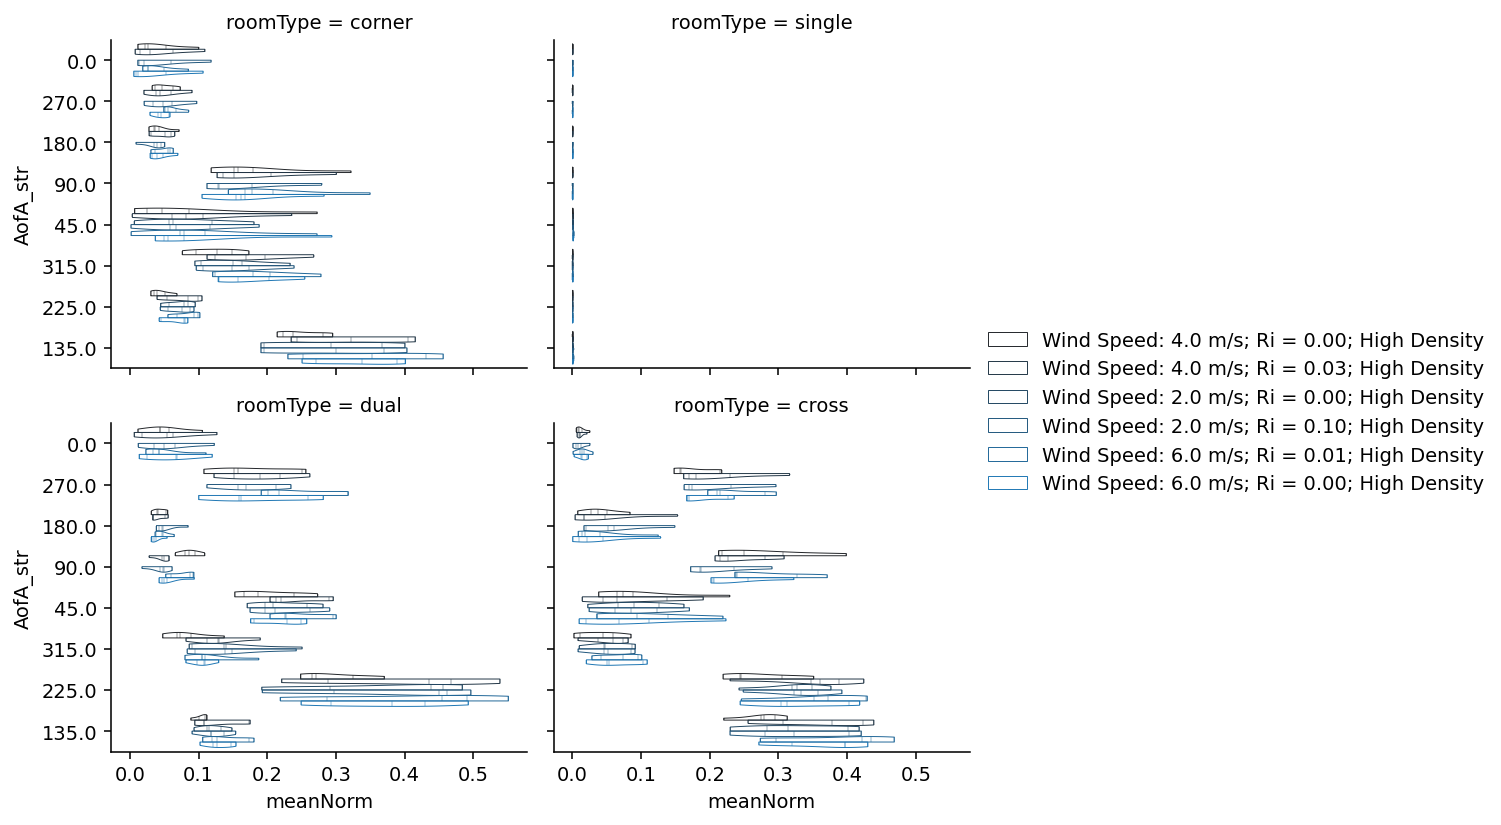

In [40]:
plotdf = roomVentilationMI[roomVentilationMI["houseType"] != "sl"]
g = sns.FacetGrid(plotdf, col = "roomType", col_wrap = 2, col_order = ["corner", "single", "dual", "cross"], aspect = 1.25, legend_out = True)
# g.map(sns.scatterplot, "meanNorm", "AofA_str", "B", style = roomVentilationMI["WS"], palette = "tab10", markers = [10, 11])
# g.map(sns.stripplot, "meanNorm", "AofA_str", "Params", palette = "tab10", size=2, dodge = True, jitter= False)
g.map(sns.violinplot, "meanNorm", "AofA_str", "Params", fill = False, inner = "stick", linewidth = .5, density_norm = "width", cut = 0, split=True)

# g.map(sns.rugplot, "meanNorm", "AofA", "B")
g.add_legend()

In [41]:
plotdf = plotdf.sort_values(["Params"])
fig1 = px.bar_polar(plotdf, r="netNorm", theta="AofA",
                   color="roomType", template="plotly_dark", pattern_shape = "WS",
                   color_discrete_sequence= px.colors.sequential.Viridis)
fig1.show()

fig2 = px.bar_polar(plotdf, r="netNorm", theta="AofA",
                   color="roomType", template="plotly_dark", pattern_shape = "B",
                   color_discrete_sequence= px.colors.sequential.Viridis)
fig2.show()

In [47]:
plotdf = plotdf.sort_values(["houseType", "Params"])
# plotdf = plotdf.sort_values("Params")
color_labels = ["Params"]
for i, color_label in enumerate(color_labels):
    plotdf_frac = plotdf.copy()
    fracN = plotdf_frac.shape[0] / (len(set(plotdf_frac["roomType"])) * len(set(plotdf_frac["AofA"])))
    plotdf_frac[["netNorm", "meanNorm"]] = plotdf_frac[["netNorm", "meanNorm"]] / fracN
    rooms = ["corner", "single", "dual", "cross"]
    # params = set(plotdf[color_label])
    # marker_color=px.colors.qualitative.Safe #["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4']
    # color_map = {}
    # for i, param in enumerate(params):
    #     color_map[i] = marker_color[i]
    # color_map = px.colors.sequential.Viridis

    figures = []
    for i, room in enumerate(rooms):
        fig = px.bar_polar(plotdf_frac[plotdf_frac["roomType"] == room], r="netNorm", theta="AofA",
                    color=color_label, template="plotly_dark", hover_data = ["houseType"],
                    color_discrete_sequence=px.colors.qualitative.Safe, title=room)
        figures.append(fig)

    fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, subplot_titles=rooms, vertical_spacing=0.2)

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            room = rooms[i]
            row = int((i/2)+1)
            col = int((i%2)+1)
            # print(row, col)
            trace = figure["data"][trace]
            if i>0:
                trace.showlegend = False
            fig.add_trace(trace, row=row, col=col)
            fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

    # fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
    fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
    fig.update_layout(width = 1000, height = 800)


    fig.show()
    fig.write_image(f'{home_dir}/CHARLES/multiPlots/radialByParams.png', scale=2)
    
    # print(fig)

In [48]:
plotdf = plotdf.sort_values(["houseType", "Params"])
# plotdf = plotdf.sort_values("Params")
color_labels = ["Params"]
for i, color_label in enumerate(color_labels):
    plotdf_frac = plotdf.copy()
    fracN = plotdf_frac.shape[0] / (len(set(plotdf_frac["roomType"])) * len(set(plotdf_frac["AofA"])))
    plotdf_frac[["netNorm", "meanNorm", "netNormEPR", "meanNormEPR"]] = plotdf_frac[["netNorm", "meanNorm", "netNormEPR", "meanNormEPR"]] / fracN
    rooms = ["corner", "single", "dual", "cross"]
    # params = set(plotdf[color_label])
    # marker_color=px.colors.qualitative.Safe #["#E4FF87", '#709BFF', '#709BFF', '#FFAA70', '#FFAA70', '#FFDF70', '#B6FFB4']
    # color_map = {}
    # for i, param in enumerate(params):
    #     color_map[i] = marker_color[i]
    # color_map = px.colors.sequential.Viridis

    figures = []
    for i, room in enumerate(rooms):
        plotdf_frac_room = plotdf_frac[plotdf_frac["roomType"] == room]
        fig = px.bar_polar(plotdf_frac_room, r="netNormEPR", theta="AofA",
                    color=color_label, template="plotly_dark", hover_data = ["houseType"],
                    color_discrete_sequence=px.colors.qualitative.Safe, title=room)
        figures.append(fig)

    fig = make_subplots(rows=2, cols=2, specs=[[{'type': 'polar'}]*2]*2, subplot_titles=rooms, vertical_spacing=0.2)

    for i, figure in enumerate(figures):
        for trace in range(len(figure["data"])):
            room = rooms[i]
            row = int((i/2)+1)
            col = int((i%2)+1)
            # print(row, col)
            trace = figure["data"][trace]
            if i>0:
                trace.showlegend = False
            fig.add_trace(trace, row=row, col=col)
            fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

    # fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.5])
    fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.5])
    fig.update_layout(width = 1000, height = 800)


    fig.show()
    fig.write_image(f'{home_dir}/CHARLES/multiPlots/radialByParamsEPR.png', scale=2)
    
    # print(fig)

In [62]:
def getComparativeDf(df, split_col, sort_cols = ['WS', 'B', 'AofA', 'C']):
    values = list(set(df[split_col]))
    display(f"splitting {split_col} along values {values}")
    sort_cols = [c for c in sort_cols if c != split_col]
    plotdfMulti = df.set_index([split_col, df.index]).sort_index(level = 0)
    dfs = []
    for v in values:
        df_v = plotdfMulti.loc[v]
        df_v = df_v.set_index([*sort_cols, df_v.index.droplevel(0)]).sort_index()
        dfs.append(df_v)
    dfComp = pd.concat(dfs, axis = "columns", keys = values)    
    dfComp = dfComp.swaplevel(axis = "columns")
    dfComp.sort_values(sort_cols, inplace=True)
    return dfComp, values

def indMulti(ind: pd.core.indexes.multi.MultiIndex, cols: list):
    data = []
    for col in cols:
        data.append(ind.get_level_values(col).astype(str))
    if len(data) == 1:
        return data[0]
    return data


In [63]:
dfCompWS, valuesWS = getComparativeDf(plotdf, "WS")
fig = px.scatter(x = dfCompWS[('netNorm', valuesWS[0])], y = dfCompWS[('netNorm', valuesWS[1])], symbol = dfCompWS[('roomType', valuesWS[0])], color = indMulti(dfCompWS.index, ['C']), hover_data = indMulti(dfCompWS.index, ['B', 'AofA']))

fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=np.max(dfCompWS["netNorm"]), 
              y1=np.max(dfCompWS["netNorm"]))

fig.update_layout(
    # xaxis_title=r'$\text{Normalized Ventilation Rate} V_{10) = 2 m/s$',
    xaxis_title=r'$U_{10} = 2 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    yaxis_title=r'$U_{10} = 4 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    # legend_title=r'Room Type',
)
fig.show()
fig.write_image(f'{home_dir}/CHARLES/multiPlots/scatterWS_2-4.png', scale=2)

fig = px.scatter(x = dfCompWS[('netNorm', valuesWS[1])], y = dfCompWS[('netNorm', valuesWS[2])], symbol = dfCompWS[('roomType', valuesWS[1])], color = indMulti(dfCompWS.index, ['C']), hover_data = indMulti(dfCompWS.index, ['B', 'AofA']))

fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=np.max(dfCompWS["netNorm"]), 
              y1=np.max(dfCompWS["netNorm"]))

fig.update_layout(
    # xaxis_title=r'$\text{Normalized Ventilation Rate} V_{10) = 2 m/s$',
    xaxis_title=r'$U_{10} = 4 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    yaxis_title=r'$U_{10} = 6 m/s, \text{Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
    # legend_title=r'Room Type',
)
fig.show()
fig.write_image(f'{home_dir}/CHARLES/multiPlots/scatterWS_4-6.png', scale=2)

'splitting WS along values [2.0, 4.0, 6.0]'

In [161]:
dfCompB, valuesB = getComparativeDf(plotdf, "B")

dfCompB = dfCompB.dropna(axis = "rows")
color_data = dfCompB[("Ri", valuesB[1])]
color_data = color_data.apply(lambda i: str(round(i, 2)))
fig = px.scatter(x = dfCompB[('netNorm', valuesB[0])], y = dfCompB[('netNorm', valuesB[1])], symbol = dfCompB[('roomType', valuesB[0])], color = color_data, hover_data = indMulti(dfCompB.index, ['C', 'AofA']))

fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=np.max(dfCompB["netNorm"]), 
              y1=np.max(dfCompB["netNorm"]))

fig.update_layout(
# xaxis_title=r'$\text{Normalized Ventilation Rate} V_{10) = 2 m/s$',
xaxis_title=r'$Ri = 0 \text{, Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
yaxis_title=r'$Ri > 0 \text{, Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
# legend_title=r'Room Type'
)

fig.show()
fig.write_image(f'{home_dir}/CHARLES/multiPlots/scatterBuoyancy.png', scale=2)

'splitting B along values [False, True]'

In [149]:
figures = []
for i, room in enumerate(rooms):
    dfRoom = dfCompB.copy()
    dfRoom["roomType"] = dfRoom["roomType"].iloc[:, 0]
    dfRoom = dfRoom[C == room]
    fig = px.scatter(x = dfCompB['netNorm'].iloc[:,0], y = dfCompB['netNorm'].iloc[:,1], symbol = dfCompB["roomType"], color = dfCompB['Ri'].iloc[:,1], hover_data = indMulti(dfCompB.index, ['C', 'AofA']))
    figures.append(fig)

fig = make_subplots(rows=2, cols=2, subplot_titles=rooms, vertical_spacing=0.2)

for i, figure in enumerate(figures):
    for trace in range(len(figure["data"])):
        room = rooms[i]
        row = int((i/2)+1)
        col = int((i%2)+1)
        # print(row, col)
        trace = figure["data"][trace]
        if i>0:
            trace.showlegend = False
        fig.add_trace(trace, row=row, col=col)
        fig.update_annotations(y=1.05 - (row-1)/1.65, selector={'text':room})

# fig.update_polars(radialaxis_dtick=.1, radialaxis_range=[0,.4])
# fig.update_polars(radialaxis_nticks=5, radialaxis_range=[0,.4])
fig.update_layout(width = 1000, height = 800)


fig.show()

KeyError: False

In [ ]:
dfCompC, valuesC = getComparativeDf(plotdf, "C")

fig = px.scatter(x = dfCompC['netNorm'].iloc[:,0], y = dfCompC['netNorm'].iloc[:,1], symbol = dfCompC["roomType"], color = indMulti(dfCompC.index, ['WS']), hover_data = indMulti(dfCompC.index, ['B', 'AofA']))

fig.add_shape(type="line",
              x0=0, 
              y0=0, 
              x1=np.max(dfCompC["netNorm"]), 
              y1=np.max(dfCompC["netNorm"]))

fig.update_layout(
# xaxis_title=r'$\text{Normalized Ventilation Rate} V_{10) = 2 m/s$',
xaxis_title=r'$\text{Buoyancy, Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
yaxis_title=r'$\text{Neutral, Normalized Ventilation Rate } [\frac{Q}{U_{10}A}]$',
# legend_title=r'Room Type'
)

fig.show()
fig.write_image(f'{home_dir}/CHARLES/multiPlots/scatterDensity.png', scale=2)

'splitting C along values [2, 3]'

In [ ]:
fig = px.histogram(
    x=[
        dfCompWS['netNorm'].iloc[:,0]/dfCompWS['netNorm'].mean(axis = "columns"), 
        dfCompWS['netNorm'].iloc[:,1]/dfCompWS['netNorm'].mean(axis = "columns"),
        dfCompWS['netNorm'].iloc[:,2]/dfCompWS['netNorm'].mean(axis = "columns"),
        ],
    histnorm = "percent",
    marginal="box", # or violin, rug
    barmode = "overlay"
    )
fig.show()
fig.write_image(f'{home_dir}/CHARLES/multiPlots/histWS.png', scale=2)

dfCompRi, valuesRi = getComparativeDf(plotdf, "Ri", sort_cols = ['AofA', 'C'])
fig = px.histogram(
    x=[
        dfCompRi['netNorm'].iloc[:,0]/dfCompRi['netNorm'].mean(axis = "columns"), 
        dfCompRi['netNorm'].iloc[:,1]/dfCompRi['netNorm'].mean(axis = "columns"),
        dfCompRi['netNorm'].iloc[:,2]/dfCompRi['netNorm'].mean(axis = "columns"),
        dfCompRi['netNorm'].iloc[:,3]/dfCompRi['netNorm'].mean(axis = "columns"),
        ],
    histnorm = "percent",
    marginal="box", # or violin, rug
    barmode = "overlay"
    )
fig.show()
fig.write_image(f'{home_dir}/CHARLES/multiPlots/histRi.png', scale=2)


'splitting Ri along values [0.0, 0.10411244143675169, 0.011568049048527965, 0.026028110359187923]'

Scatter plot showing 1 to 1 line
- Ventilation changes due to house location
- Ventilation changes due to wind parameterization
- Ventilation changes due to buoyancy